# Laboratorio 4
## 1) Problema minimi quadrati
Data una matrice $A$ di dimensioni $m × n$ con $m \ge n$ ed un vettore $y$ di $m$ componenti, il problema dei minimi quadrati è il seguente: 
$$\alpha^\ast = \arg \min_{\alpha}\|A\alpha − y\|^2_2$$
Questo problema di minimo può essere risolto in due modi:
+ **Metodo delle equazioni normali.** Se A ha rango massimo il problema di minimo può essere riscritto in maniera equivalente come segue: $A^T A\alpha = A^T y$. Questo sistema si può risolvere utilizzando la fattorizzazione LU o di Cholesky (dato che la matrice $A^T A$ è simmetrica).
+ **SVD.** Se A non ha rango massimo il problema è sottodeterminato, quindi ha più di una soluzione. In questo caso si considera la decomposizione SVD della matrice $A = USV^T$ dove $U \in \mathbb{R}^{m×m}$ e $V^T \in \mathbb{R}^{n×n}$ matrici ortogonali e $S \in \mathbb{R}^{m×n}$ diagonale. Da questa decomposizione si può calcolare esplicitemente la soluzione di minima norma del problema di minimi quadrati come segue: 
$$\alpha = \sum_{i=0}^r \dfrac{(u_i^T \: y) \: v_i}{s_i}.$$

Assegnata una matrice $A$ di numeri casuali di dimensione $m × n$ con $m > n$, generata utilizzando la funzione `np.random.rand`, scegliere un vettore $\alpha$ (per esempio con elementi costanti) come soluzione per creare un problema test e calcolare il termine noto $y = A\alpha$.
Definito quindi il problema di minimi quadrati con la matrice A ed il termine noto $y$ calcolato:
+ Calcolare la soluzione del problema risolvendo le equazioni normali mediante la fattorizzazione LU e Cholesky.
+ Calcolare la soluzione del problema usando la SVD della matrice A.
+ Calcolare l’errore relativo delle soluzioni trovate, rispetto al vettore $\alpha$, soluzione esatta,  tilizzata per generare il problema test.

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy.linalg import lu_factor as LUdec 

m = 100
n = 10

A = np.random.rand(m, n)
alpha_test = np.ones(n)
y = np.matmul(A,alpha_test)
print("alpha test", alpha_test)

ATA = A.T@A
ATy = A.T@y
lu, piv = LUdec(ATA)
alpha_LU = scipy.linalg.lu_solve((lu,piv), ATy)
print("alpha LU", alpha_LU)

L = scipy.linalg.cholesky(ATA)
x = scipy.linalg.solve_triangular(np.transpose(L), ATy, lower=True)
alpha_chol = scipy.linalg.solve_triangular(L, x, lower=False)
print("alpha chol", alpha_chol)

U, s, Vh = scipy.linalg.svd(A)
print("Shape of U:", U.shape)
print("Shape of s:", s.shape)
print("Shape of V:", Vh.T.shape)
alpha_svd = np.zeros(s.shape)
for i in range(n):
  ui = U[:, i]
  vi = Vh[i, :]
  alpha_svd += (np.matmul(np.transpose(ui),y)) * vi / s[i] 
print("alpha SVD", alpha_svd)

print("Errore relativo LU:", np.linalg.norm(alpha_LU-alpha_test)/np.linalg.norm(alpha_test))
print("Errore relativo Cholesky:", np.linalg.norm(alpha_chol-alpha_test)/np.linalg.norm(alpha_test))
print("Errore relativo SVD:", np.linalg.norm(alpha_svd-alpha_test)/np.linalg.norm(alpha_test))

alpha test [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
alpha LU [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
alpha chol [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Shape of U: (100, 100)
Shape of s: (10,)
Shape of V: (10, 10)
alpha SVD [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Errore relativo LU: 8.361313600747657e-15
Errore relativo Cholesky: 7.696016036893705e-15
Errore relativo SVD: 1.4619575968827475e-15


## 2) Approssimazione di un set di dati tramite Minimi Quadrati
Sia $\{(x_i , y_i)\}^m_{i=0}$ un set di dati, che devono essere approssimati da un polinomio di grado $n \in \mathbb{N}$ fissato.
$$
p(x) = \alpha_0 + \alpha_1 x + \dots+ \alpha_n x^n
$$
Per calcolare i coefficienti del polinomio si deve risolvere un problema di minimi quadrati in cui la matrice A è definita come segue: 
$$
A = \begin{bmatrix} 1 & x_0 & x^2_0 & \dots & x^n_0\\ 1 & x_1 & x^2_1 & \dots & x^n_1\\ \vdots & \vdots & \vdots & \vdots & \vdots\\ 1 & x_m & x^2_m & \dots & x^n_m \end{bmatrix}
$$
Mentre il termine noto è:
$$
y = \begin{bmatrix} y_0\\ \vdots\\ y_m \end{bmatrix}
$$

Date le seguenti funzioni:
+ $f(x) = exp(x/2) \quad x \in [-1,1]$
+ $f(x) = \dfrac{1}{1+25x^2} \quad x \in [-1,1]$
+ $f(x) = sin(x) + cos(x) \quad x \in [0, 2\pi]$
Si eseguano le seguenti richieste per ciascuna delle funzioni date:
1. Calcolare $m = 10$ coppie di punti $(x_i, f(x_i))$.
2. Per $n$ fissato, calcolare una soluzione del problema di minimi quadrati, descritto sopra, utilizzando un metodo a scelta tra quelli utilizzati nell’esercizio precedente.
3. Per ciascun valore di $n \in \{1, 2, 3, 5, 7\}$, creare una figura con il grafico della funzione esatta $f(x)$ insieme a quello del polinomio di approssimazione $p(x)$, evidenziando gli $m$ punti noti.
4. Per ciascun valore di $n \in \{1, 2, 3, 5, 7\}$, calcolare e stampare il valore del residuo in norma 2 commesso nei punti $x_i$.

In [84]:
m = 10
m_plot = 100
n_fixed = 9

def approx(x, y, n, pos):
    print("Grado:", n)
    A = np.zeros((m, n+1))
    for i in range(n+1):
      A[:, i] = x ** i
    U, s, Vh = scipy.linalg.svd(A)
    alpha_svd = np.zeros(n+1)
    for i in range(n+1):
      ui = U[:, i]
      vi = Vh[i, :]
      alpha_svd += (np.matmul(np.transpose(ui),y)) * vi / s[i]
    print("SVD:", alpha_svd)
    
    x_plot = np.linspace(x[0], x[-1], m_plot)
    A_plot = np.zeros((m_plot, n+1))
    for i in range(n+1):
      A_plot[:, i] = x_plot ** i
    y_interpolation = np.matmul(A_plot, alpha_svd)
    ax = plt.subplot(2, 3, pos)
    plt.plot(x, y, "o")
    plt.plot(x_plot, y_interpolation, "r")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Grado " + str(n))
    plt.grid()
    res = np.linalg.norm(y - np.matmul(A, alpha_svd))
    print("Residuo: ", res, "\n")
    
def plotApprox(x,y,x_real,y_real,title=""):
    plt.figure()
    ax = plt.subplot(2, 3, 1)
    plt.plot(x_real, y_real)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid()
    # Calcola e plotta le interpolazioni per i gradi 1, 2, 3, 5, 7 e per il grado n_fixed
    for i in range(4):
      approx(x, y, 2*i+1, i+2)
    approx(x, y, n_fixed, 6)
    plt.tight_layout()
    plt.show()

Grado: 1
SVD: [1.05169894 0.51523297]
Residuo:  0.145433382884694 

Grado: 3
SVD: [0.99969023 0.49991905 0.12765775 0.0211677 ]
Residuo:  0.0008263727821353013 

Grado: 5
SVD: [1.00000060e+00 5.00000139e-01 1.24988092e-01 2.08320882e-02
 2.63709877e-03 2.63076547e-04]
Residuo:  1.477729918707959e-06 

Grado: 7
SVD: [1.00000000e+00 5.00000000e-01 1.25000017e-01 2.08333348e-02
 2.60406567e-03 2.60410030e-04 2.18828985e-05 1.56077952e-06]
Residuo:  8.737821526123543e-10 

Grado: 9
SVD: [1.00000000e+00 5.00000000e-01 1.25000000e-01 2.08333333e-02
 2.60416675e-03 2.60416671e-04 2.17010276e-05 1.55008280e-06
 9.74308368e-08 5.40726217e-09]
Residuo:  4.680087186316848e-15 


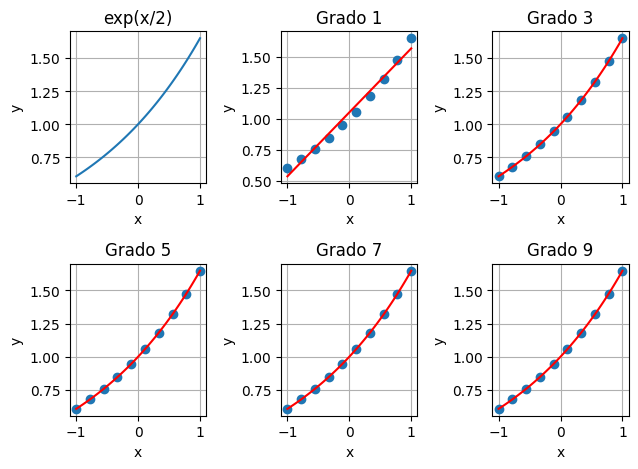

In [85]:
# f(x) = exp(x/2) x ∈ [−1,1]
x = np.linspace(-1,1,m)
y = np.exp(x/2)
x_real = np.linspace(-1,1,m_plot)
y_real = np.exp(x_real/2)
plotApprox(x,y,x_real,y_real,"exp(x/2)")

Grado: 1
SVD: [2.48814136e-01 8.59440460e-17]
Residuo:  0.8519889898800778 

Grado: 3
SVD: [ 4.74479148e-01 -1.61631194e-16 -5.53905029e-01  4.48358990e-16]
Residuo:  0.5751808755886041 

Grado: 5
SVD: [ 6.42191979e-01  1.44617678e-16 -1.99646993e+00 -1.89573840e-15
  1.42497265e+00  1.91286346e-15]
Residuo:  0.3631838354754461 

Grado: 7
SVD: [ 7.67384095e-01  3.43649734e-14 -4.47552598e+00  3.57914182e-14
  8.29218923e+00 -9.36430145e-16 -4.54921187e+00  4.71019911e-14]
Residuo:  0.1939183846601575 

Grado: 9
SVD: [ 8.61538152e-01 -3.29114189e-14 -8.26092333e+00  3.49664299e-13
  3.07285300e+01 -1.39679438e-12 -4.49154581e+01  2.09190777e-12
  2.16247748e+01 -1.01043877e-12]
Residuo:  1.2320279204302288e-14 


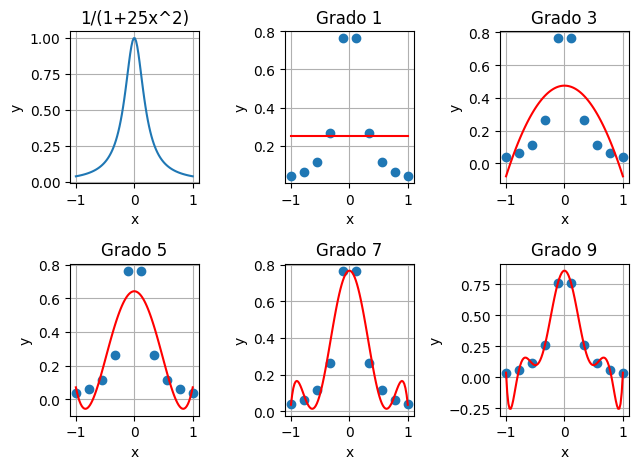

In [86]:
# f(x) = 1/(1+25x^2) x ∈ [−1,1]
x = np.linspace(-1,1,m)
y = 1/(1+25*(x**2))
x_real = np.linspace(-1,1,m_plot)
y_real = 1/(1+25*(x_real**2))
plotApprox(x,y,x_real,y_real,"1/(1+25x^2)")

Grado: 1
SVD: [ 0.77438082 -0.21466208]
Residuo:  2.8367505921049365 

Grado: 3
SVD: [ 1.19282899  0.46222741 -0.60469494  0.08496876]
Residuo:  0.80077077177318 

Grado: 5
SVD: [ 0.99315181  1.18619381 -0.77082962 -0.07787167  0.06176099 -0.00551072]
Residuo:  0.06559431617548454 

Grado: 7
SVD: [ 1.00003083e+00  9.77531789e-01 -4.34564755e-01 -2.32885792e-01
  7.02987169e-02  4.47279780e-03 -2.32165017e-03  1.50714072e-04]
Residuo:  0.0016911098620954945 

Grado: 9
SVD: [ 1.00000000e+00  1.00220513e+00 -5.08527514e-01 -1.53701153e-01
  3.14535288e-02  1.28292784e-02 -2.43887396e-03 -1.21889995e-04
  4.50547545e-05 -2.29369460e-06]
Residuo:  2.4380430318822677e-09 


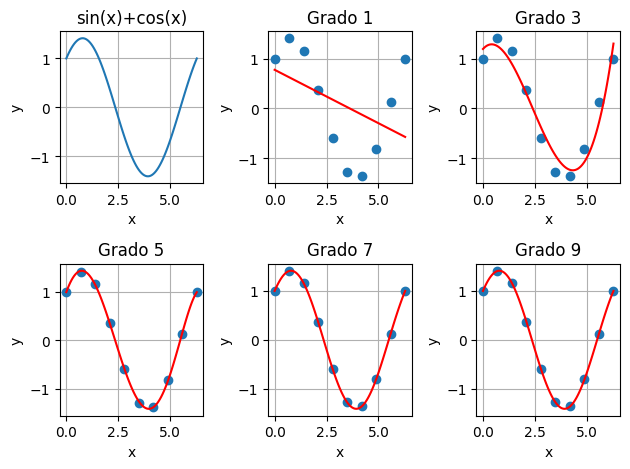

In [87]:
# f(x) = sin(x)+cos(x) x ∈ [0,2π]
x = np.linspace(0,2*np.pi,m)
y = np.sin(x)+np.cos(x)
x_real = np.linspace(0,2*np.pi,m_plot)
y_real = np.sin(x_real)+np.cos(x_real)
plotApprox(x,y,x_real,y_real,"sin(x)+cos(x)")